### What is the CompEcon Toolbox?

* It is a MATLAB toolbox supporting Miranda and Fackler (2005): "Applied Computational Economics and Finance".


* The library functions include:
    * Rootfinding and optimization solvers
    * Function approximation using polynomials, splines and other functional families
    * Numerical integration
    * Solvers for Ordinary Differential Equations
    * Routines solving discrete and continuous time dynamic programming problems
    * Solvers for financial derivatives


* The toolbox has been translated to **Julia** by Spencer Lyon.

### Interpolations Using CompEcon

* The CompEcon toolbox allows us to compute interpolations for:

    * Any number of dimensions
    * Any order of derivative and integral operators
    * Any order B-spline, Chebyshev polynomial, and piecewise linear basis functions
    * We can mix among different types of families across dimensions (i.e. Chebychev for x and splines for $\epsilon$)

### Structure of the Toolbox - Julia Version

* Think on 3 main "theoretical" categories:

    1. A functional `Basis`: Family of basis functions; Domain; Interpolation Nodes [see `basis.jl`].
    2. A `BasisStructure` representation: it evaluates the basis functions at the desired interpolation nodes [see `basis_structure.jl`].
    3. Coefficient vector: map from the domain of the `Basis` to the real line [obtained by solving linear system of equations].


* This general structure is going to become clearer once we go into an example model.


* This theoretical construct is mapped into **Julia** by defining groups of types


See https://github.com/spencerlyon2/CompEcon.jl

### Group of Types

**Group 1:** types to represent the `Basis` in `Basis.jl`.
* `BasisFamily`: abstract type that defines the interpolant families.
```
abstract BasisFamily
immutable Cheb <: BasisFamily end
immutable Lin <: BasisFamily end
immutable Spline <: BasisFamily end
```
* `BasisParams`: abstract type whose fields are all info needed to construct *univariate* basis.
```
type ChebParams <: BasisParams
    n::Int
    a::Float64
    b::Float64
end
```
```
type SplineParams <: BasisParams
    breaks::Vector{Float64}
    evennum::Int
    k::Int
end
```
```
type LinParams <: BasisParams
    breaks::Vector{Float64}
    evennum::Int
end
```

* `Basis{N}`:
```
type Basis{N, BF<:BasisFamily, BP<:BasisParams}
    basistype::Vector{BF}  # Basis family
    n::Vector{Int}         # number of points and/or basis functions
    a::Vector{Float64}     # lower bound of domain
    b::Vector{Float64}     # upper bound of domain
    params::Vector{BP}     # params to construct basis
end
```

* Finally note that inside this file there are two additional useful functions:

    1. `nodes`: given the chosen `Basis`, it computes the nodes.
    2. `Basis`: used to define the basis and also to create multidimensional basis.
   

**Group 2:** type to represent the `BasisStructure` in `basis_structure.jl`.

* `AbstractBasisStructureRep` [`ABSR`]: it groups the types of representation (Tensor, Direct, Expanded).


* An important function is `BasisStructure`.

    * Its inputs are the `basis`, the type of representation (Tensor, etc) and the nodes.
    * Its output is the interpolant valued at the nodes, $\Phi$ (Matrix).

* Another interesting function is `Base.convert` which converts from a `Tensor` or `Direct` `BasisStructure` to an `Expanded` one.


* For example, the following will convert from direct to expanded.
```
Φ_direct = BasisStructure(basis, CompEcon.Direct(),snodes,0)
Φ = convert(Expanded, Φ_direct, [0 0]).vals[1]
```


* In the end we will need the expanded version, but the other two are more efficient in terms of storage.

## Quick Example (Same as Spencer's GitHub)

### One Dimension:
Approximate  $f(x)=e^{-x}$ on $x\in[-1,1]$ using the three types of interpolations.

For a known univariate function $f(x)$ there are 3 ways to approximate it. I will do the three of them, but changing the basis type (Cheb and Splines).

```
using CompEcon
f(x) = exp(-x)
a,b = -1.0,1.0
```
*** Option 1: Using `funfitf`***
```
n = 10
basis_c = Basis(Cheb, n, a, b)
c_c = funfitf(basis_c, f)
```

*** Option 2: Using `funfitxy`***
```
xgrid = collect(linspace(a,b,n))
basis_s = Basis(Spline, xgrid, 0, 1)
x_s = nodes(basis_s)[1]
y_s = f(x_s)
c_s = funfitxy(basis_s, x_s, y_s)[1]
```
*** Option 3: Using `BasisStructure`***
```
x_c = nodes(basis_c)[1]
y_c = f(x_c)
phi_c = BasisStructure(basis_c).vals[1]
c_c2 = phi_c\y_c
```

In [ ]:
using CompEcon
f(x) = exp(-x)

# Set the endpoints of approximation interval:
a =  -1.0                            # left endpoint
b =   1.0                            # right endpoint
n = 10                             # order of approximation

# Option 1: (with Cheb)
basis_c = Basis(Cheb, n, a, b)
c_c = funfitf(basis_c, f)

# Option 2: (with Spline)
xgrid = collect(linspace(a,b,n))
basis_s = Basis(Spline, xgrid, 0, 1)
x_s = nodes(basis_s)[1]
y_s = f(x_s)
c_s = funfitxy(basis_s, x_s, y_s)[1]


# Option 3: (with Cheb again)
x_c = nodes(basis_c)[1]
y_c = f(x_c)
phi_c = BasisStructure(basis_c, CompEcon.Expanded(),x_c).vals[1]
c_c2 = phi_c\y_c


# Compare different approaches
print("Coefficients from options 1 and 3")
[c_c c_c2]

In [ ]:
# Having computed the basis coefficients, one may now evaluate the
# approximant at any point x using funeval:
xvals = collect(linspace(-1.0,1.0,50))
y_c = funeval(c_c, basis_c, xvals)
y_s = funeval(c_s, basis_s, xvals)
yy = f(xvals)

yvals = [y_c y_s yy]

Method = ["Cheb", "Spline", "True Function"]

using PyPlot
fig, ax = subplots()
for i=1:3
    meth = Method[i]
    ax[:plot](xvals, yvals[:,i], linewidth=2, alpha=0.6, label=L"$Method$ ="" $meth")
end
ax[:legend](loc=1)

### Two Dimensions:

Let the "state" be given by $s=(a,y)$. I take the function $f(s) = \sqrt{a}\exp{(y)}$. To generate the interpolation, I use a linear spline for the first variable and a Chebichev polynomial for the second. Then I plot the true value and the interpolation, for different values of $s$.

In this example, we get a better approximation by mixing splines and Chebychev, than by just using Chebychev in both arguments.

In [ ]:
fun2(st) = sqrt(st[:,1]).*exp(st[:,2])

agrid0 = collect(linspace(0.0,10.0,10))

a_basis = Basis(Spline, agrid0, 0, 1)
y_basis = Basis(Cheb, 10, 0.0, 10.0)
basis2 = Basis(a_basis, y_basis)

c_2d = funfitf(basis2, fun2)

avals  = collect(linspace(0.0,10.0,50))
yvals  = collect(linspace(0.0,10.0,50))
svals  = [avals yvals]
y_val  = funeval(c_2d, basis2, svals)
y_true = fun2(svals)

yvals2d = [y_val y_true]


Method = ["Interpolation", "True Function"]

using PyPlot

fig, ax = subplots()
for i=1:2
    meth = Method[i]
    ax[:plot](1:1:50, yvals2d[:,i], linewidth=2, alpha=0.6, label=L"$Method$ ="" $meth")
end
ax[:legend](loc=1)


### Baseline Model: Economic Growth

* Consider an economy that produces and consumes a single composite good.
* Infinite horizon. Continuous state and action.
* At the begining of period $t$ it has $s\in(0,\infty)$ units, of which invests $x\in[0,s)$.
* State transition function: $s=g(s,x,\epsilon)=\gamma x+\epsilon f(x)$.
* Rewards function:
\begin{equation}
F(s,x)=u(s-x)=\frac{(s-x)^{1-\alpha}}{1-\alpha}
\end{equation}
* Bellman Equation:
\begin{equation}
V\left(\left[x,\epsilon\right]\right)=\max_{0\leq x'\leq s=g\left(x,\epsilon\right)}\left\{\right\}
\end{equation}
* Assume $u'(0)=-\infty$ and $h(0)=0$

* From FOC, we get the Euler equation:
\begin{equation}
u_{t}'=\delta E_{t}\left[u_{t+1}'\left(\gamma+\epsilon_{t+1}f_{t}'\right)\right]
\end{equation}
* Certainty Equivalent Steady State ($\epsilon=1$):
    * $u'\left(s^{*}-x^{*}\right)=\delta\lambda^{*}\left[\gamma+f'\left(x^{*}\right)\right]$
    * $\lambda^{*}=u'\left(s^{*}-x^{*}\right)$
    * $s^{*}=\gamma x^{*}+f\left(x^{*}\right)$
    
    
* CE SS conditions imply the golden rule $1-\gamma+r=f'(x^{*})$ where $\delta=1/(1+r)$

To approximate the solution, I follow Simon Mongey's notes given during Gianlucca Violante's course.
   
   * Define the set of collocation nodes $s = [\mathbf{1}_{Nz}\otimes{}\mathbf{X},\mathbf{Z}\otimes{}\mathbf{1}_{Nx}]$ and let $N=N_{x}\text{x}N_{z}$
   
   * We can define the following system:
   \begin{equation}
   V(s_{i}) = \max_{x'\in B(s_{i})}F(s_{i},x')+\beta V_{e}([x',s_{i,2}]) \\
   V_{e}(s_{i}) = \sum_{k=1}^{Nz}P(z,z_{k}')V([s_{i,1},z'_{k}])
   \end{equation}
   
   
   * If we substitute for the interpolants:
   
   \begin{equation}
   \sum_{j=1}^{N}\phi(s_{i})c_{j}= \max_{x'\in B(s_{i})}F(s_{i},x')+\beta\sum_{j=1}^{N}\phi([x',s_{i,2}])c_{j}^{e} \\
   \sum_{j=1}^{N}\phi(s_{i})c_{j}^{e}= \sum_{k=1}^{Nz}P(z,z_{k}')\sum_{j=1}^{N}\phi([s_{i,1},z'_{k}])c_{j}
   \end{equation}

   * ... and write it in a stacked form, we get:
   
     \begin{equation}
   \Phi(s) = \max_{x'\in\mathbf{B}(s)}F(s,x')+\beta\Phi([x',s_{2}])c^{e} \\
   \Phi(s)c^{e} = (P\otimes{}\mathbf{I}_{Nx})\Phi(s)c
   \end{equation}
   
   
   * The following scripts solves this model using Julia's version of CompEcon written by Spencer Lyon.

* In the following first block I define the Economic Growth model type EconGrowth and auxiliary functions. Some of them are going to be part of the EconGrowth model, since are intrinsic to this specific model.


* In particular, these functions are the utility function, the production function and the law of motion for wealth.
The auxiliary functions are for the discretization of the stochastic process and the definition of the basis.

In [1]:
using CompEcon

# Step 0: Define the Economic Growth model type EconGrowth

type EconGrowth
    a::Float64
    b::Float64
    nx::Int64
    m::Int64
    σ::Float64
    δ::Float64
    u::Function # Utility function. Will already have the parameters.
    f::Function # Production function. Idem.
    g::Function # Law of Motion for state. Idem.
    tol::Float64 # Tolerance Level.
    maxit::Int # Maximum iterations.
end


# Step 1: Define the model's functions

function def_funs(α::Float64,β::Float64,γ::Float64)
    f(x::Array{Float64,1}) = x.^β
    g(sn::Array{Float64,2}) = γ*sn[:,1] + sn[:,2].*f(sn[:,1])
    u(sn::Array{Float64,2},xprime::Array{Float64,1}) = (g(sn)-xprime).^(1-α)./(1-α)
    
    return f,g,u
end


# Step 2: Define function to discretize stochastic process

function discretize(eg::EconGrowth)

    ϵ,ω = qnwlogn(eg.m,0,eg.σ^2) # quadrature for lognormal
    P = repmat(ω',eg.m,1) # Since the process is i.i.d but I wanted to keep the general structure.
    
    return ϵ,ω,P
end


# Step 3: Define function to create the Basis for s and s'

function get_nodes(eg::EconGrowth,ϵ::Array{Float64,1})
#     x_basis = Basis(Cheb, eg.nx, eg.a, eg.b) # Create basis from chosen type of interpolation
    xgrid = collect(linspace(1e-1,eg.b,eg.nx))
    x_basis = Basis(Spline, xgrid, 0, 1) # Create Splines
    z_basis = Basis(Lin, ϵ, 0) # Create linear

    basis  = Basis(x_basis,z_basis) # Combine both basis to have multidimensional basis structure
    snodes = nodes(basis)[1] # get the collection of nodes for hte (joint) state S
    return basis,snodes
end


# For s', we will have a new set of nodes, since the first column changes when we maximize
function get_phi(basis,snodes_prime)
    Φ = BasisStructure(basis, CompEcon.Expanded(),snodes_prime).vals[1] # Compute the multidimensional basis structure
end


get_phi (generic function with 1 method)

* Next I write down:
    * the optimization problem
    * the one-setp update function
    * and the iteration function
    
    
* For the optimization I choose the CompEcon Golden Method search algorithm. Alternativley I could use a Newton-Rhapson method.


* For solving the Bellman Equation using the collocation nodes I just iterate. Alternatively I could use some Newton rootfinding algorithm.

In [2]:
# Step 4: Write the Optimization Problem
function obj_fun(eg::EconGrowth,basis,snodes,ce::Array{Float64,1})
    
#     obj(xp::Array{Float64,1}) = eg.u(snodes,xp) + eg.δ*min(get_phi(basis,[xp snodes[:,2]])*ce,0.0)
    obj(xp::Array{Float64,1}) = eg.u(snodes,xp) + eg.δ*get_phi(basis,[xp snodes[:,2]])*ce
    
    x_sol,f_sol = golden_method(obj, zeros(size(snodes,1)), eg.g(snodes))
    
end


# Step 5: Write down the iterative procedure (one-step)
# Bellman Iteration

function one_step(eg::EconGrowth,cc::Vector{Float64},ce::Vector{Float64},basis,snodes,Φ1,ϵ,P)
    xsol,fsol = obj_fun(eg,basis,snodes,ce)
    f2 = kron(P,eye(eg.nx))*Φ1*cc
    
    cc_out = Φ1\fsol
    ce_out = Φ1\f2
    
    return cc_out,ce_out
end

one_step (generic function with 1 method)

In [66]:
# Step 6: Define the iteration function
function iter(eg::EconGrowth)
    iteration = 0
    di = 1

    cc = zeros(eg.nx*eg.m)
    ce = zeros(eg.nx*eg.m)
    
    ϵ,ω,P = discretize(eg::EconGrowth)
    
    basis,snodes = get_nodes(eg,ϵ)
    
    Φ1 = get_phi(basis,snodes)

    while di>eg.tol
        iteration += 1
            if iteration > eg.maxit
                break
            else
                cc0 = copy(cc)
                ce0 = copy(ce)
                cc,ce = one_step(eg,cc0,ce0,basis,snodes,Φ1,ϵ,P)

                resid1 = norm(cc0-cc)
                resid2 = norm(ce0-ce)

                di = max(resid1,resid2)
#             @printf("Iteration %d with distance %.3f\n", iteration, di)
            end
    end
    
    @printf("The total number of interations was %d.\n", iteration)
    
    return cc,ce,basis,Φ1
end

iter (generic function with 1 method)

* Finally I give values to the parameters and use it for input to the EconGrowth type.
* With that I can solve the model, given this set of parameters.
* Then I plot investment (x) in percentage to wealth (s).

In [67]:
a,b,nx,m = 0.0,10.0,10,3
α,β,γ = 2.0, 0.5, 0.9
f,g,u = def_funs(α::Float64,β::Float64,γ::Float64)
σ,δ = 0.1, 0.9


# Computation of the Steady State
r_ss = 1/δ-1
x_ss = ((1/β)*(1/δ-γ))^(1/(β-1))
s_ss = γ*x_ss+x_ss^β
c_ss = s_ss-x_ss
lambda_ss = (c_ss)^(-α)
vals_ss = [r_ss,x_ss,s_ss,c_ss,lambda_ss]

@printf("The steady values are r = %.2f, x = %.2f, s = %.2f, c = %.2f.\n"
,vals_ss[1],vals_ss[2],vals_ss[3],vals_ss[4])

# Solution to the Model

tol, maxit = 1e-9,10000
eg = EconGrowth(a,b,nx,m,σ,δ,u,f,g,tol,maxit)
cc,ce,basis,Φ1 =iter(eg)

@printf("The vector of coefficients cc and ce are:\n")
[cc ce]

The steady values are r = 0.11, x = 5.61, s = 7.42, c = 1.81.
The total number of interations was 421.
The vector of coefficients cc and ce are:


30x2 Array{Float64,2}:
 -31.0785   -30.2021 
  -9.8449    -9.55267
  -7.76525   -7.56519
  -6.76857   -6.60286
  -6.13826   -5.98989
  -5.67882   -5.54812
  -5.32542   -5.2123 
  -5.0414    -4.94195
  -4.80463   -4.71469
  -4.60148   -4.51799
 -30.2289   -30.2021 
  -9.5616    -9.55267
  -7.57034   -7.56519
   ⋮                 
  -4.71641   -4.71469
  -4.52054   -4.51799
 -29.2185   -30.2021 
  -9.22474   -9.55267
  -7.34452   -7.56519
  -6.42982   -6.60286
  -5.84422   -5.98989
  -5.42237   -5.54812
  -5.09908   -5.2123 
  -4.8377    -4.94195
  -4.61788   -4.71469
  -4.42429   -4.51799

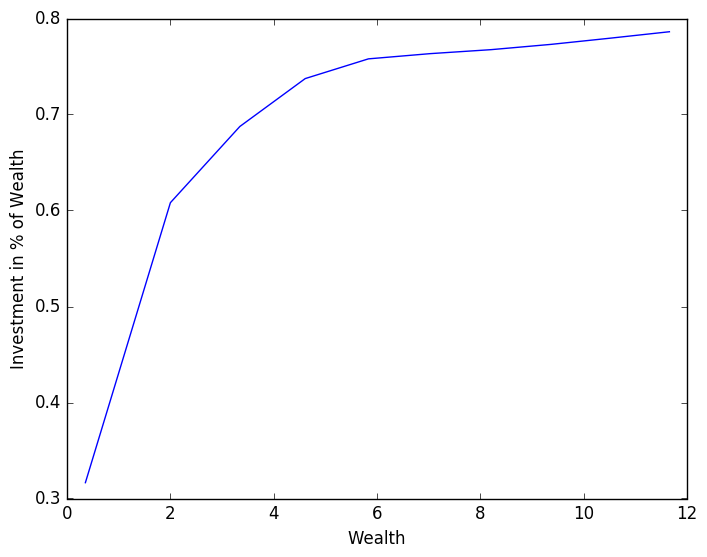

(PyObject <matplotlib.text.Text object at 0x31631e1d0>,PyObject <matplotlib.text.Text object at 0x316327590>)

In [41]:
using PyPlot

ϵ,ω,P = discretize(eg)

basis,snodes = get_nodes(eg,ϵ)

Φ1 = get_phi(basis,snodes)

xsol,fsol = obj_fun(eg,basis,snodes,ce)

s = eg.g(snodes)
yplot = (xsol)./s
res = Φ1*cc-fsol

plot(s[1:eg.nx],yplot[1:nx])
xlabel("Wealth"), ylabel("Investment in % of Wealth")
